In [0]:
#import findspark
#findspark.init()
from pyspark.sql import SparkSession


spark = SparkSession.builder.appName("enigh").getOrCreate()

In [0]:
%matplotlib inline

In [0]:
import sys

from pyspark.sql.types import StringType, DateType, FloatType

from pyspark.sql.window import Window

from pyspark.sql.functions import col, substring, when, countDistinct, length, lit, sum, avg, count, min, window, mean, round

import numpy as np
import pandas as pd
import json
import os

pd.set_option('display.max_columns',None)

In [0]:
%fs rm -r dbfs:/FileStore/tables/enigh/catalogos-csv/clave.csv

res1: Boolean = true

In [0]:

%fs ls dbfs:/FileStore/tables/enigh/catalogos-csv/

path,name,size
dbfs:/FileStore/tables/enigh/catalogos-csv/clave.csv,clave.csv,58747
dbfs:/FileStore/tables/enigh/catalogos-csv/forma_pag1.csv,forma_pag1.csv,275
dbfs:/FileStore/tables/enigh/catalogos-csv/lugar_comp.csv,lugar_comp.csv,521


In [0]:
dbfs:/FileStore/tables/enigh/catalogos-csv/

In [0]:
# muestra
df = spark.read.csv('/FileStore/tables/enigh/data_limpia.csv', header = True)
# ENIGH completa
#df = spark.read.csv('/FileStore/tables/enigh/gastoshogar_limpia_completa.csv', header = True)

df_claves = spark.read.csv('/FileStore/tables/enigh/catalogos-csv/clave.csv', header = True)

df_estados = spark.read.csv('/FileStore/tables/enigh/estados.csv', header = True)

In [0]:
df = df.withColumn(
    "cantidad", col("cantidad").cast(FloatType())
).withColumn(
    "gasto", col("gasto").cast(FloatType())
).withColumn(
    "gasto_tri", col("gasto_tri").cast(FloatType())
)

In [0]:
df.printSchema()
df_claves.printSchema()
df_estados.printSchema()

root
 |-- folioviv: string (nullable = true)
 |-- foliohog: string (nullable = true)
 |-- clave: string (nullable = true)
 |-- mes_dia: string (nullable = true)
 |-- forma_pag1: string (nullable = true)
 |-- lugar_comp: string (nullable = true)
 |-- cantidad: float (nullable = true)
 |-- gasto: float (nullable = true)
 |-- gasto_tri: float (nullable = true)
 |-- clave codificación: string (nullable = true)
 |-- forma_pag1 codificación: string (nullable = true)
 |-- lugar_comp codificación: string (nullable = true)

root
 |-- clave: string (nullable = true)
 |-- clave codificación: string (nullable = true)
 |-- clave2: string (nullable = true)
 |-- rubro: string (nullable = true)

root
 |-- clave_edo: string (nullable = true)
 |-- Enitidad: string (nullable = true)



# Cruce tablas

In [0]:
recreación_clave2 = []

In [0]:
df_claves.groupBy('clave2', 'rubro').agg(count(col('clave2'))).orderBy('clave2').display()

clave2,rubro,count(clave2)
A001,abarrotes,222
A003,bebidas alcoholicas y tabaco,20
A005,alimentos fura del hogar,6
B001,transporte publico,8
C001,articulos hogar,25
D001,cuidado personal,27
E001,"educacion basica, media o superior",7
E002,servicios o articulos educacion,14
E003,cultura y recreacion,14
F001,comunicaciones,6


In [0]:
# join con clave de gasto
df_f = df.join(df_claves, ['clave'], 'left')
# crear columna con 'clave_edo' y hacer join con df_estados
df_f = df_f.withColumn('clave_edo', substring(col('folioviv'), 1, 2))
df_f = df_f.join(df_estados, ['clave_edo'], 'left')
# crear columna con tipo de area
df_f = df_f.withColumn('area', when(substring(col('folioviv'), 3, 1) == '6', 'rural').otherwise('urbano'))
# crear columna con mes
df_f = df_f.withColumn('mes', when(length(col('mes_dia')) == 3, substring(col('mes_dia'), 1, 1)).when(length(col('mes_dia')) == 4, substring(col('mes_dia'), 1, 2)).otherwise(lit(None).cast(StringType())))


In [0]:
## crear df con cum de hogares por are y estado
num_hog_edo_area = df_f.groupBy('clave_edo', 'area').agg(countDistinct('folioviv', 'foliohog').alias('count_hog_edo_area')).orderBy('clave_edo', 'area')
num_hog_edo = df_f.groupBy('clave_edo').agg(countDistinct('folioviv', 'foliohog').alias('count_hog_edo')).orderBy('clave_edo')
df_num_hog = num_hog_edo_area.join(num_hog_edo, ['clave_edo']).orderBy('clave_edo', 'area')

In [0]:
df_num_hog.show(9)

+---------+------+------------------+-------------+
|clave_edo|  area|count_hog_edo_area|count_hog_edo|
+---------+------+------------------+-------------+
|       01| rural|               299|          761|
|       01|urbano|               462|          761|
|       02| rural|               606|         1188|
|       02|urbano|               582|         1188|
|       03| rural|               269|          826|
|       03|urbano|               557|          826|
|       04| rural|               163|          613|
|       04|urbano|               450|          613|
|       05| rural|               199|         1073|
+---------+------+------------------+-------------+
only showing top 9 rows



In [0]:
df_f.drop('clave_edo', 'clave', 'mes_dia', 'forma_pag1', 'lugar_comp', 'clave2').filter(col('gasto').isNotNull() & col('mes').isNotNull()).orderBy('folioviv').show(30)
# display(
#     df_f.filter(col('area') == 'rural').select('folioviv', 'mes_dia', 'mes', 'area')
# )

+----------+--------+--------+-----+---------+--------------------+-----------------------+-----------------------+--------------------+--------------------+--------------+------+---+
|  folioviv|foliohog|cantidad|gasto|gasto_tri|  clave codificación|forma_pag1 codificación|lugar_comp codificación|  clave codificación|               rubro|      Enitidad|  area|mes|
+----------+--------+--------+-----+---------+--------------------+-----------------------+-----------------------+--------------------+--------------------+--------------+------+---+
|0100522604|       1|     4.0| 22.0|   282.85|Leche pasteurizad...|                   null|                   null|Leche pasteurizad...|           abarrotes|Aguascalientes|urbano| 09|
|0101080301|       1|     2.0| 16.0|   205.71|Leche pasteurizad...|                   null|                   null|Leche pasteurizad...|           abarrotes|Aguascalientes|urbano| 09|
|0101080301|       1|     2.0| 12.0|   154.28|Leche pasteurizad...|             

# Exploración

## transformaciones

In [0]:
df_f.printSchema()

root
 |-- clave_edo: string (nullable = true)
 |-- clave: string (nullable = true)
 |-- folioviv: string (nullable = true)
 |-- foliohog: string (nullable = true)
 |-- mes_dia: string (nullable = true)
 |-- forma_pag1: string (nullable = true)
 |-- lugar_comp: string (nullable = true)
 |-- cantidad: float (nullable = true)
 |-- gasto: float (nullable = true)
 |-- gasto_tri: float (nullable = true)
 |-- clave codificación: string (nullable = true)
 |-- forma_pag1 codificación: string (nullable = true)
 |-- lugar_comp codificación: string (nullable = true)
 |-- clave codificación: string (nullable = true)
 |-- clave2: string (nullable = true)
 |-- rubro: string (nullable = true)
 |-- Enitidad: string (nullable = true)
 |-- area: string (nullable = false)
 |-- mes: string (nullable = true)



### gastos

In [0]:
df_gastos = df_f.groupBy("folioviv", "foliohog", "Enitidad", "area", 'mes', "rubro", "forma_pag1 codificación", "lugar_comp codificación", "clave_edo", "clave2", "forma_pag1", "lugar_comp").agg(
    sum('gasto').alias('gasto_mes'),
    count('gasto').alias('num_compras'),
    round(avg('gasto_tri'), 4).alias('prom_gasto_tri')
)

In [0]:
df_gastos.drop('clave_edo', 'Entitidad', 'area', 'clave2', 'forma_pag1', 'lugar_comp').orderBy('folioviv', 'clave2', 'foliohog', 'mes').limit(10).show()

+----------+--------+--------------+----+--------------------+-----------------------+-----------------------+---------+-----------+--------------+
|  folioviv|foliohog|      Enitidad| mes|               rubro|forma_pag1 codificación|lugar_comp codificación|gasto_mes|num_compras|prom_gasto_tri|
+----------+--------+--------------+----+--------------------+-----------------------+-----------------------+---------+-----------+--------------+
|0100013606|       1|Aguascalientes|  09|           abarrotes|               Efectivo|   Tiendas de abarrotes|     48.0|          2|        308.57|
|0100013606|       1|Aguascalientes|  09|           abarrotes|               Efectivo|   Tiendas específic...|    125.0|          5|       321.424|
|0100013606|       1|Aguascalientes|  10|           abarrotes|               Efectivo|   Tiendas de conven...|     58.0|          2|        372.85|
|0100013606|       1|Aguascalientes|  10|           abarrotes|               Efectivo|   Tiendas específic...|  

#### notas

cómo se normaliza el "gasto_tri"? y por qué tiene valores diferentes para los mismos rubros?

es válido sacar el promedio para el mes?

In [0]:
df_gastos.groupBy('foliohog', 'folioviv', 'mes').agg(sum('gasto_mes')).orderBy('folioviv', 'mes').show(5)

+--------+----------+----+-----------------+
|foliohog|  folioviv| mes|   sum(gasto_mes)|
+--------+----------+----+-----------------+
|       1|0100013605|null|           7632.0|
|       1|0100013605|  09|            293.0|
|       1|0100013605|  10|852.8999996185303|
|       1|0100013606|null|           3852.0|
|       1|0100013606|  09|            173.0|
+--------+----------+----+-----------------+
only showing top 5 rows



### porcentaje gastos

In [0]:
# df se llama "mes_prom" y tiene una columna de gasto promedio por mes, pero realmente se usatrabaja más con la totalidad de gastos regitrados en los cuestionarios, ya que con el promedio se complica sacar porcentajes
df_mes_prom = df_gastos.groupBy("folioviv", "foliohog", "Enitidad", "area", "rubro", "forma_pag1 codificación", "lugar_comp codificación", "clave_edo", "clave2", "forma_pag1", "lugar_comp").agg(
    sum('num_compras').alias('num_compras'),
    sum('gasto_mes').alias('suma'),
    round(avg('gasto_mes'), 4).alias('prom_mes'),
    round(avg('prom_gasto_tri'), 4).alias('prom_tri')
)

wdw_hog = Window.partitionBy('folioviv', 'foliohog')
wdw_hog_fpag = Window.partitionBy('folioviv', 'foliohog', 'forma_pag1')
wdw_hog_rubro = Window.partitionBy('folioviv', 'foliohog', 'clave2')
wdw_hog_lugar = Window.partitionBy('folioviv', 'foliohog', 'lugar_comp')

df_mes_prom_concepto = df_mes_prom.withColumn(
    "tot_gasto_hog", sum(col('suma')).over(wdw_hog)
).withColumn(
    "suma_pct_hog", round(col('suma')/col('tot_gasto_hog')*100, 4)
).withColumn(
    "gasto_hog_rubro", sum(col('suma')).over(wdw_hog_rubro)
).withColumn(
    "pct_hog_rubro", round(col('suma')/col('gasto_hog_rubro')*100, 4)
).withColumn(
    "gasto_hog_fpag", sum(col('suma')).over(wdw_hog_fpag)
).withColumn(
    "pct_hog_fpag", round(col('suma')/col('gasto_hog_fpag')*100, 4)
).withColumn(
    "gasto_hog_lugar", sum(col('suma')).over(wdw_hog_lugar)
).withColumn(
    "pct_hog_lugar", round(col('suma')/col('gasto_hog_lugar')*100, 4)
)



In [0]:
df_mes_prom_concepto.select('folioviv', 'foliohog', 'num_compras', 'suma', 'prom_mes', 'prom_tri', 'tot_gasto_hog', 'suma_pct_hog', "rubro", 'gasto_hog_rubro', 'pct_hog_rubro', "forma_pag1 codificación", 'gasto_hog_fpag', 'pct_hog_fpag', "lugar_comp codificación", 'gasto_hog_lugar', 'pct_hog_lugar').filter(col('suma').isNotNull()).orderBy('folioviv').limit(15).display()

folioviv,foliohog,num_compras,suma,prom_mes,prom_tri,rubro,tot_gasto_hog,suma_pct_hog,gasto_hog_rubro,pct_hog_rubro,forma_pag1 codificación,gasto_hog_fpag,pct_hog_fpag,lugar_comp codificación,gasto_hog_lugar,pct_hog_lugar
0100013606,1,16,524.0,262.0,393.8916,abarrotes,4577.0,11.4485,725.0,72.2759,Efectivo,4577.0,11.4485,Tiendas específicas del ramo,1504.0,34.8404
0100013606,1,1,400.0,400.0,1200.0,"combustible, matenimiento, servicios y refacciones vehiculos",4577.0,8.7393,400.0,100.0,Efectivo,4577.0,8.7393,null,2029.0,19.7141
0100013606,1,2,58.0,58.0,372.85,abarrotes,4577.0,1.2672,725.0,8.0,Efectivo,4577.0,1.2672,Tiendas de conveniencia,58.0,100.0
0100013606,1,1,400.0,400.0,1200.0,comunicaciones,4577.0,8.7393,400.0,100.0,Efectivo,4577.0,8.7393,null,2029.0,19.7141
0100013606,1,7,143.0,71.5,276.426,abarrotes,4577.0,3.1243,725.0,19.7241,Efectivo,4577.0,3.1243,Tiendas de abarrotes,143.0,100.0
0100013606,1,7,308.0,308.0,132.0,articulos hogar,4577.0,6.7293,308.0,100.0,Efectivo,4577.0,6.7293,Supermercados,843.0,36.5362
0100013606,1,7,535.0,535.0,229.2857,cuidado personal,4577.0,11.6889,715.0,74.8252,Efectivo,4577.0,11.6889,Supermercados,843.0,63.4638
0100013606,1,1,180.0,180.0,540.0,cuidado personal,4577.0,3.9327,715.0,25.1748,Efectivo,4577.0,3.9327,Tiendas específicas del ramo,1504.0,11.9681
0100013606,1,4,1229.0,1229.0,839.625,recibos,4577.0,26.8516,1229.0,100.0,Efectivo,4577.0,26.8516,null,2029.0,60.5717
0100013606,1,1,800.0,800.0,782.6,cuidados de la salud,4577.0,17.4787,800.0,100.0,Efectivo,4577.0,17.4787,Tiendas específicas del ramo,1504.0,53.1915


### estados y area

In [0]:
df_num_hog.show(7)

+---------+------+------------------+-------------+
|clave_edo|  area|count_hog_edo_area|count_hog_edo|
+---------+------+------------------+-------------+
|       01| rural|               299|          761|
|       01|urbano|               462|          761|
|       02| rural|               606|         1188|
|       02|urbano|               582|         1188|
|       03| rural|               269|          826|
|       03|urbano|               557|          826|
|       04| rural|               163|          613|
+---------+------+------------------+-------------+
only showing top 7 rows



In [0]:
df_gasto_estados = df_mes_prom.groupBy("Enitidad", "clave_edo", "area", "rubro", "forma_pag1 codificación", "lugar_comp codificación", "clave2", "forma_pag1", "lugar_comp").agg(
    sum('num_compras').alias('num_compras'),
    sum('suma').alias('gasto_edo'),
    round(avg('prom_mes'), 4).alias('prom_mes_edo'),
    round(avg('prom_tri'), 4).alias('prom_tri_edo')
)

df_gasto_estados = df_gasto_estados.join(df_num_hog, ['clave_edo', 'area'])

wdw_edo_area = Window.partitionBy('clave_edo', 'area')
wdw_edo_fpag = Window.partitionBy('clave_edo', 'area', 'forma_pag1')
wdw_edo_rubro = Window.partitionBy('clave_edo', 'area', 'clave2')
wdw_edo_lugar = Window.partitionBy('clave_edo', 'area', 'lugar_comp')

df_gasto_estados = df_gasto_estados.withColumn(
    "tot_gasto_edo", sum(col('gasto_edo')).over(wdw_edo_area)
).withColumn(
    "suma_pct_edo", round(col('gasto_edo')/col('tot_gasto_edo')*100, 4)
).withColumn(
    "gasto_edo_rubro", sum(col('gasto_edo')).over(wdw_edo_rubro)
).withColumn(
    "pct_edo_rubro", round(col('gasto_edo')/col('gasto_edo_rubro')*100, 4)
).withColumn(
    "gasto_edo_fpag", sum(col('gasto_edo')).over(wdw_edo_fpag)
).withColumn(
    "pct_edo_fpag", round(col('gasto_edo')/col('gasto_edo_fpag')*100, 4)
).withColumn(
    "gasto_edo_lugar", sum(col('gasto_edo')).over(wdw_edo_lugar)
).withColumn(
    "pct_edo_lugar", round(col('gasto_edo')/col('gasto_edo_lugar')*100, 4)
)


In [0]:
df_gasto_estados.select('count_hog_edo_area', 'Enitidad', 'area', 'num_compras', 'gasto_edo', 'prom_mes_edo', 'prom_tri_edo', 'tot_gasto_edo', 'suma_pct_edo', "rubro", 'gasto_edo_rubro', 'pct_edo_rubro', "forma_pag1 codificación", 'gasto_edo_fpag', 'pct_edo_fpag', "lugar_comp codificación", 'gasto_edo_lugar', 'pct_edo_lugar').orderBy('clave_edo', 'area').limit(15).display()

count_hog_edo_area,Enitidad,area,num_compras,gasto_edo,prom_mes_edo,prom_tri_edo,tot_gasto_edo,suma_pct_edo,rubro,gasto_edo_rubro,pct_edo_rubro,forma_pag1 codificación,gasto_edo_fpag,pct_edo_fpag,lugar_comp codificación,gasto_edo_lugar,pct_edo_lugar
299,Aguascalientes,rural,10,263.0,65.75,498.2088,4773515.279980183,0.0055,abarrotes,245091.77998018265,0.1073,null,668462.0,0.0393,null,1587407.0,0.0166
299,Aguascalientes,rural,43,43936.0,1021.7674,3012.9605,4773515.279980183,0.9204,bebidas alcoholicas y tabaco,49380.5,88.9744,null,668462.0,6.5727,null,1587407.0,2.7678
299,Aguascalientes,rural,6,357.0,59.5,764.9933,4773515.279980183,0.0075,alimentos fura del hogar,29388.0,1.2148,null,668462.0,0.0534,null,1587407.0,0.0225
299,Aguascalientes,rural,3,246.0,82.0,238.06,4773515.279980183,0.0052,transporte publico,246.0,100.0,null,668462.0,0.0368,null,1587407.0,0.0155
299,Aguascalientes,rural,6,1436.0,287.2,839.186,4773515.279980183,0.0301,articulos hogar,170467.0,0.8424,null,668462.0,0.2148,null,1587407.0,0.0905
299,Aguascalientes,rural,10,1495.0,166.1111,473.91,4773515.279980183,0.0313,cuidado personal,198433.0,0.7534,null,668462.0,0.2236,null,1587407.0,0.0942
299,Aguascalientes,rural,2,6040.0,3020.0,8997.095,4773515.279980183,0.1265,"educacion basica, media o superior",6040.0,100.0,null,668462.0,0.9036,null,1587407.0,0.3805
299,Aguascalientes,rural,0,null,null,null,4773515.279980183,null,servicios o articulos educacion,10526.0,null,null,668462.0,null,null,1587407.0,null
299,Aguascalientes,rural,0,null,null,null,4773515.279980183,null,cultura y recreacion,6367.0,null,null,668462.0,null,null,1587407.0,null
299,Aguascalientes,rural,0,null,null,null,4773515.279980183,null,comunicaciones,94025.0,null,null,668462.0,null,null,1587407.0,null


#### nota

[count distinct over a window](https://stackoverflow.com/questions/60672901/get-total-row-count-over-a-window)

``` python
w = Window.partitionBy("i").orderBy("j").rowsBetween(-sys.maxsize,sys.maxsize)

df.withColumn("count",count(col("j")).over(w)).show()
```

In [0]:

wdw_edos_area = Window.partitionBy('clave_edo', 'area').rowsBetween(-sys.maxsize,sys.maxsize)

df_gasto_estados = df_mes_prom.groupBy("clave_edo", "area", "clave codificación", "forma_pag1 codificación", "lugar_comp codificación", "clave", "forma_pag1", "lugar_comp").agg(
    sum('gasto_tot_hog_gpo').alias('gasto_edo'),
    round(avg('prom_mes'), 4).alias('prom_mes_edo'),
    round(avg('prom_tri'), 4).alias('prom_tri_edo'),
    countDistinct('folioviv', 'foliohog').alias('num_hog_gpo')
).withColumn(
    "num_hog_edo", count(col('gasto_edo')).over(wdw_edos_area)
)

## Analisis

### estados y area

#### rubro

In [0]:
edo_rubro = df_gasto_estados.select('count_hog_edo_area', 'Enitidad', 'area', 'num_compras', 'gasto_edo', 'prom_mes_edo', 'prom_tri_edo', 'tot_gasto_edo', 'suma_pct_edo', "rubro", 'gasto_edo_rubro', 'pct_edo_rubro', "forma_pag1 codificación", 'gasto_edo_fpag', 'pct_edo_fpag', "lugar_comp codificación", 'gasto_edo_lugar', 'pct_edo_lugar').orderBy('clave_edo', 'area')

In [0]:
# df_gasto_estados.groupBy('clave2', 'area').select('Enitidad', 'area', 'gasto_edo', 'prom_mes_edo', 'prom_tri_edo',  "rubro",, 'tot_gasto_edo', 'suma_pct_edo', 'gasto_edo_rubro', 'pct_edo_rubro', "forma_pag1 codificación", 'gasto_edo_fpag', 'pct_edo_fpag', "lugar_comp codificación", 'gasto_edo_lugar', 'pct_edo_lugar').agg(
#     sum(col('num_compras')).alias('num_compras'),
#     sum(col('num_compras')).alias('num_compras') 
# ).orderBy('clave_edo', 'area').limit(15).display()

#### lugar

#### forma pago

### mes promedio

## Viz

[facet grid](https://blog.devgenius.io/data-analysis-using-facetgrid-visualization-of-seaborn-882606408c39)

[hist](https://seaborn.pydata.org/generated/seaborn.histplot.html)

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

In [0]:
df_pd = df_f.toPandas()
pd_pct_gastos = df_mes_prom_concepto.toPandas()
pd_estados = df_gasto_estados.toPandas()

In [0]:
# sns.displot(
#     pd_pct_gastos[pd_pct_gastos['prom_mes'] < 10000],
#     x="prom_mes",
#     col="rubro", col_wrap=5,
#     hue="forma_pag1",
#     kind="hist"
# )

In [0]:
sns.catplot(data = pd_pct_gastos[pd_pct_gastos['prom_mes'] < 10000],
            x = 'forma_pag1',
            y = 'prom_mes',
            kind = 'box',
            col="Enitidad",
            col_wrap=5
)
plt.show()

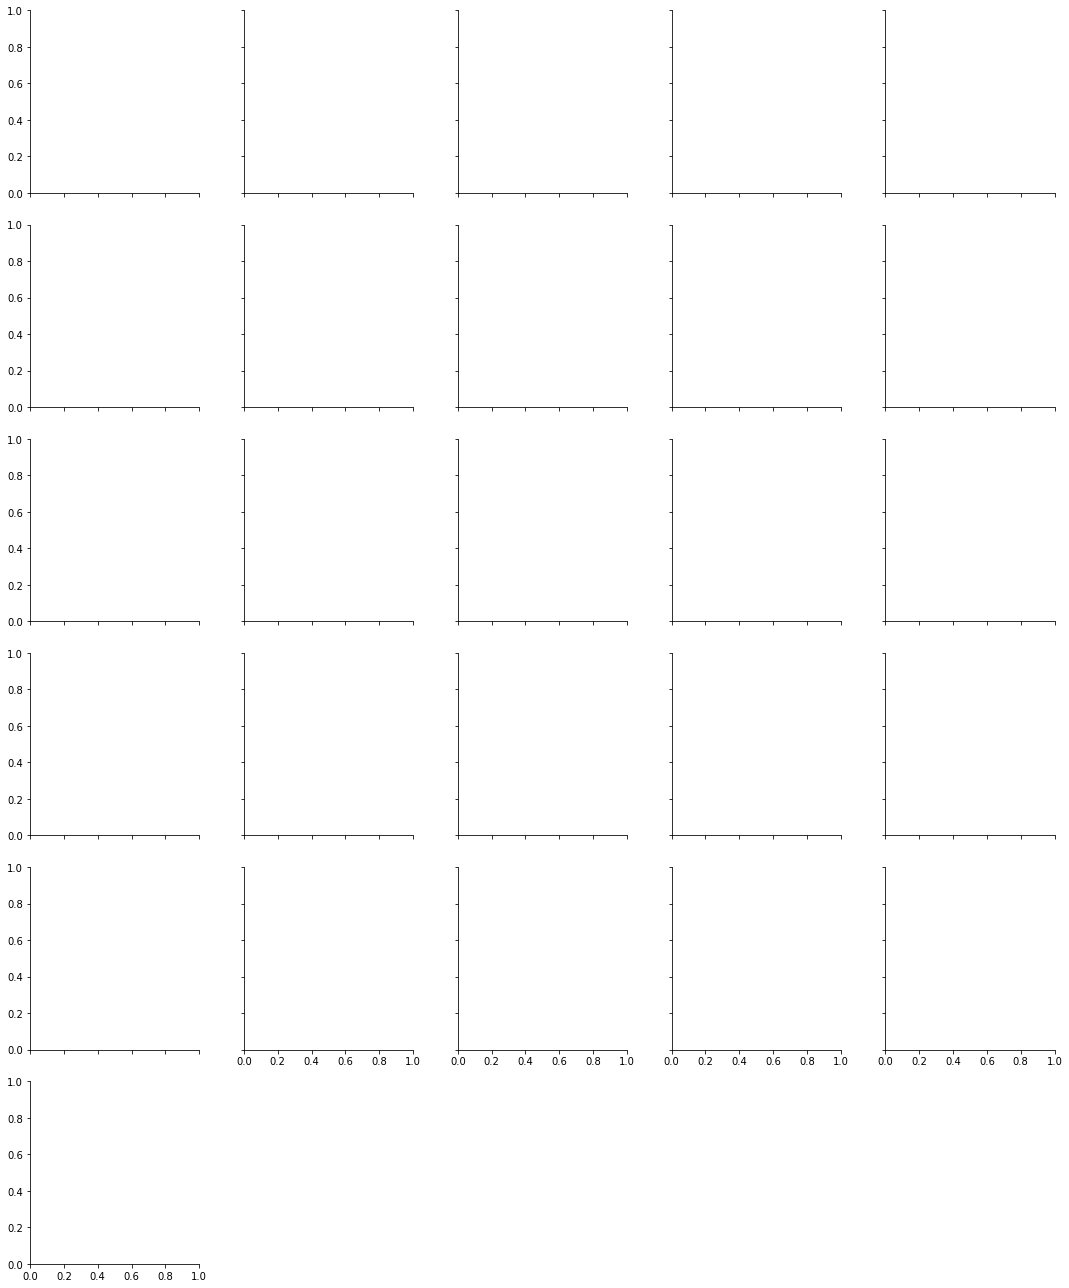

---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
<command-1666643203285116> in <module>
      1 g = sns.FacetGrid(pd_pct_gastos[pd_pct_gastos['prom_mes'] < 10000], col='rubro', col_wrap=5, hue="forma_pag1", margin_titles=True)
----> 2 g.map(sns.displot, x="prom_mes")

/databricks/python/lib/python3.8/site-packages/seaborn/axisgrid.py in map(self, func, *args, **kwargs)
    681 
    682             # Draw the plot
--> 683             self._facet_plot(func, ax, plot_args, kwargs)
    684 
    685         # Finalize the annotations and layout

/databricks/python/lib/python3.8/site-packages/seaborn/axisgrid.py in _facet_plot(self, func, ax, plot_args, plot_kwargs)
    773             plot_args = []
    774             plot_kwargs["ax"] = ax
--> 775         func(*plot_args, **plot_kwargs)
    776 
    777         # Sort out the supporting information

/databricks/python/lib/python3.8/site-

In [0]:
sns.catplot(data = pd_pct_gastos[pd_pct_gastos['prom_mes'] < 15000],
            x = 'forma_pag1',
            y = 'prom_mes',
            kind = 'box',
            col="rubro",
            col_wrap=5
)
plt.show()

In [0]:
sns.catplot(data = pd_pct_gastos[pd_pct_gastos['prom_mes'] < 15000],
            x = 'forma_pag1',
            y = 'prom_mes',
            kind = 'box',
            col="Enitidad",
            col_wrap=5
)
plt.show()

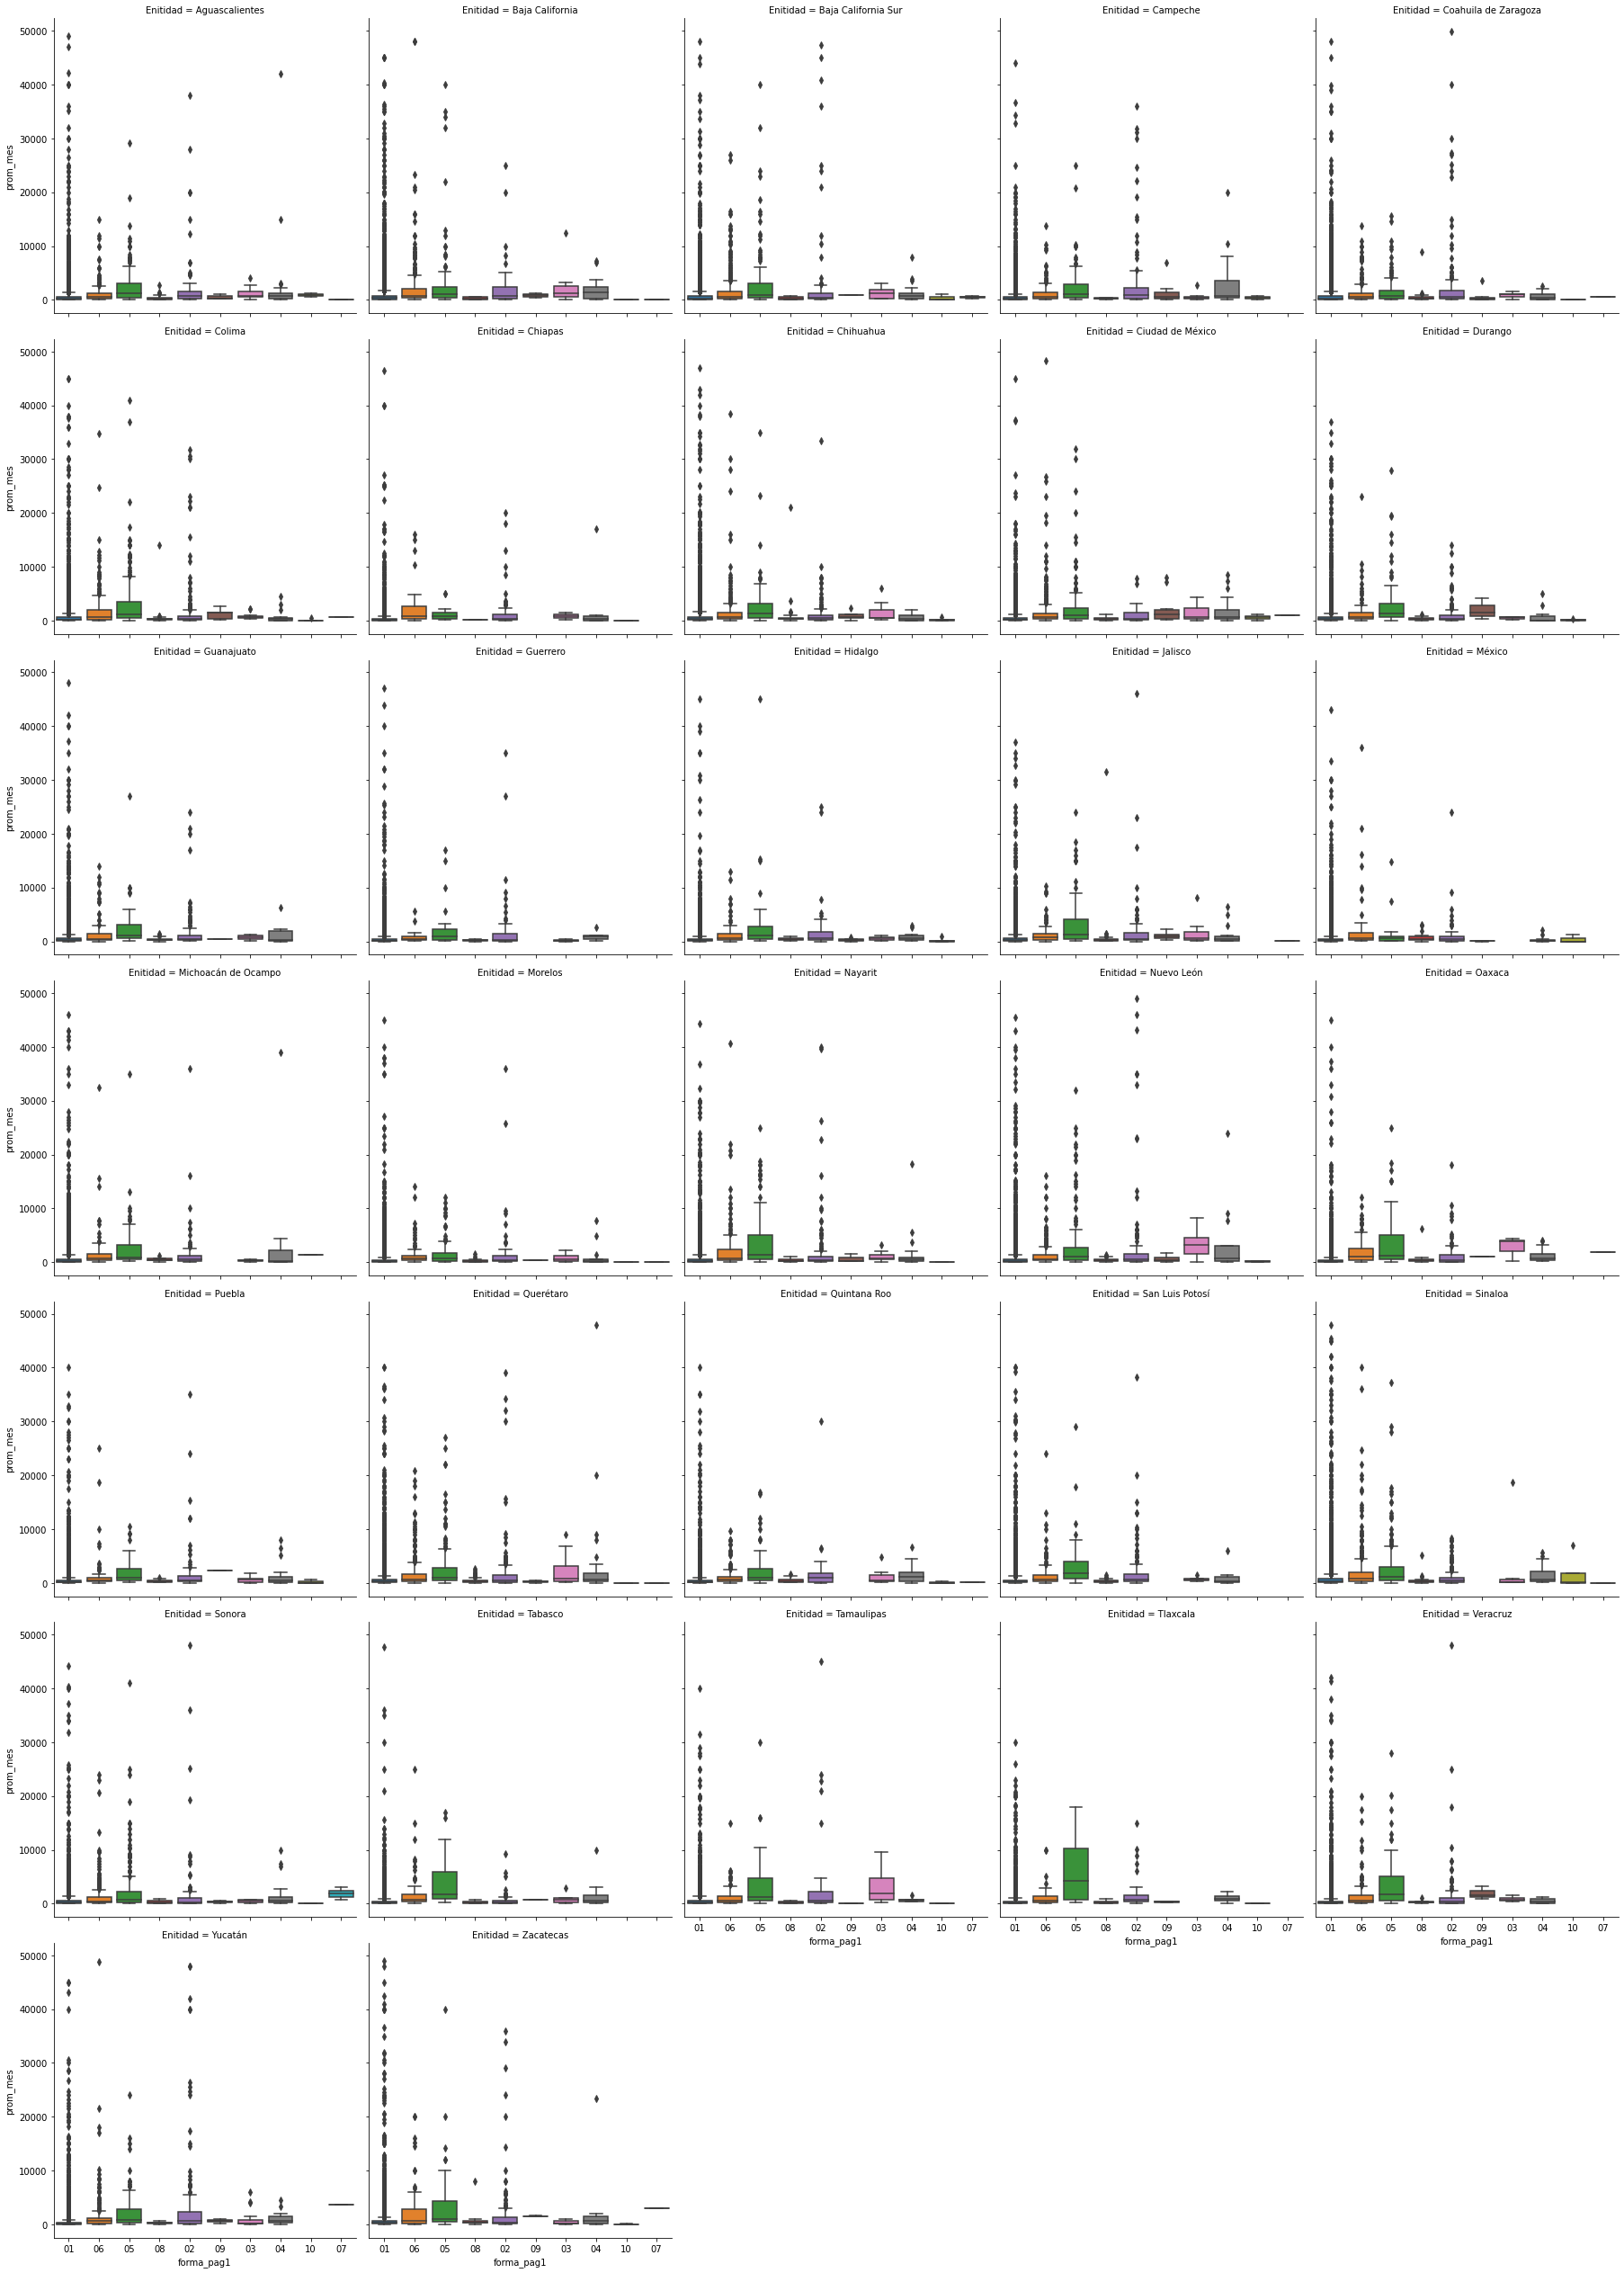

In [0]:
sns.catplot(data = pd_pct_gastos[pd_pct_gastos['prom_mes'] < 15000],
            x = 'forma_pag1',
            y = 'prom_mes',
            kind = 'box',
            col="Enitidad",
            col_wrap=5,
            margin_titles=True
)
plt.show()

In [0]:
# sns.catplot(data = pd_pct_gastos,
#             x = 'lugar_comp',
#             y = 'gasto',
#             kind = 'box',
#             col="Enitidad",
#             col_wrap=5
# )
# plt.show()

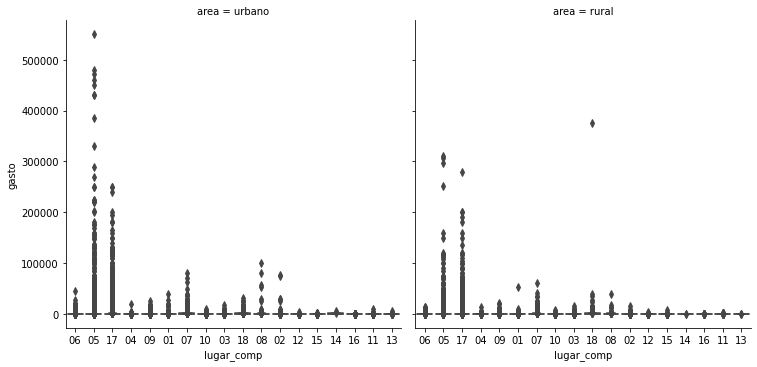

In [0]:
sns.catplot(data = df_pd,
            x = 'lugar_comp',
            y = 'gasto',
            kind = 'box',
            col="area",
            col_wrap=5
)
plt.show()

## 1